## Análisis exploratorio de la información.

### Cargue de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.options.display.float_format = '{:.6f}'.format

### Entendimiento del problema

A partir del dataset de properatti, el objetivo es entrenar un modelo que pueda predecir el precio por m2 de una propiedad, variable que en el dataset aparece como 'price_usd_per_m2'. 

Es necesario entender la data a través de un análisis exploratorio del dataset calculando algunas estadísticas y mediante la visualización de variables que a priori consideramos puedan tener un poder de predicción importante.

En seguida, realizaremos una limpieza del dataset, imputando registros cuando se considere pertinente y en otros casos omitiendo registros por considerarlos incompletos, además de buscar la consistencia en los datos. También se realizará un análisis de valores extremos.

Finalmente, con la data resultante, fijaremos un objetivo en cuando al tipo de propiedad y/o localizaciones para las cuales entrenaremos un modelo de regresión lineal.

### Lectura del dataset de Properatti

In [3]:
data = pd.read_csv('properatti.csv')

### Análisis exploratorio de la información

In [5]:
# Tamaño del dataset

data.shape

(121220, 26)

In [6]:
# Revisión de los primeros registros del dataset

data.head(2)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.000000,"-34.6618237,-58.5088387",-34.661824,...,40.000000,1127.272727,1550.000000,nan,nan,nan,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.000000,"-34.9038831,-57.9643295",-34.903883,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [7]:
# Listado de columnas o variables disponibles

data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [8]:
# Tras una revisión visual de las primeras filas del dataset decidimos sacar tres columnas del dataset las cuales no tendremos en cuenta
# para futuros análisis

data.drop(columns={'Unnamed: 0','properati_url','image_thumbnail'}, inplace=True)

In [9]:
# Revisión del tipo de dato de cada variable

data.dtypes

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
description                    object
title                          object
dtype: object

In [10]:
# Hallamos algunas estadísticas de las variables continuas del dataset

data.describe()

,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,102503.000000,69670.000000,69670.000000,100810.000000,100810.000000,100810.000000,81892.000000,101313.000000,68617.000000,87658.000000,7899.000000,47390.000000,14262.000000
mean,3574442.317893,-34.626210,-59.266290,468525.925444,4229396.828743,239700.576928,233.795328,133.050181,2160.086916,6912.215705,17.452336,3.080840,5009.234469
std,354130.624157,1.980936,2.299922,2260100.589128,6904714.125574,391323.875732,1782.222147,724.351479,2759.288621,28378.644734,120.243621,1.860773,120440.255650
min,3427208.000000,-54.823985,-75.678931,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,1.510204,1.000000,1.000000,1.000000
25%,3430234.000000,-34.669065,-58.727040,110000.000000,1583309.440000,89733.880000,50.000000,45.000000,1218.181818,1550.000000,1.000000,2.000000,1000.000000
50%,3433910.000000,-34.597985,-58.480128,185000.000000,2558452.500000,145000.000000,84.000000,75.000000,1800.000000,2213.114754,3.000000,3.000000,2000.000000
75%,3836668.000000,-34.441299,-58.395908,420000.000000,4675792.500000,265000.000000,200.000000,150.000000,2486.411765,3355.548611,6.000000,4.000000,4000.000000
max,6948895.000000,4.545843,-53.733330,650000000.000000,821271104.300000,46545445.000000,200000.000000,187000.000000,206333.333333,3999999.960000,3150.000000,32.000000,10001500.000000


In [11]:
# Eliminación de registros duplicados en caso de que existan

data.drop_duplicates(inplace=True)

# Revisamos el tamaño del dataset después de eliminar los registros duplicados

data.shape

(116140, 23)

Podemos observar que habían 5080 registros duplicados, ya que la cantidad de filas del dataset original es 121220 y la cantidad de filas eliminando duplicados es 116140.

In [12]:
# Chequeamos la cantidad de valores nulos para cada variable del dataset

val_nulos_inicial = data.isnull().sum()
val_nulos_inicial

operation                          0
property_type                      0
place_name                        23
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    18180
lat-lon                        48289
lat                            48289
lon                            48289
price                          17556
currency                       17557
price_aprox_local_currency     17556
price_aprox_usd                17556
surface_total_in_m2            38378
surface_covered_in_m2          18853
price_usd_per_m2               49289
price_per_m2                   30443
floor                         108481
rooms                          69941
expenses                      102055
description                        2
title                              0
dtype: int64

### Visualizaciones iniciales de las variables del dataset

De forma preliminar estamos interesados en revisar la distribución de variables sobre la distribución espacial de las propiedades como latitud y longitud, participación por tipo de propiedad, distribución de áreas según el tipo de propiedad y precio por metro cuadrado en función del tipo de propiedad.

#### Latitud y longitud utilizando una muestra

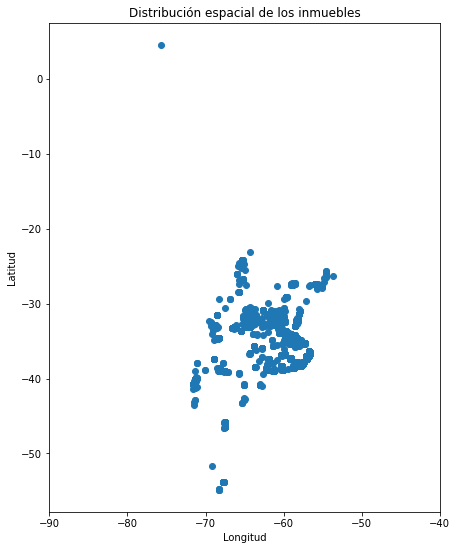

In [13]:
# Tomamos una muestra de 5000 registros y nos damos idea de una distribución espacial

muestra = data.loc[(data['lat'].notnull())&(data['lon'].notnull()),['lat', 'lon']].sample(5000)
plt.figure(1, figsize=(7,9))
plt.scatter(x=data['lon'], y=data['lat'])
plt.title('Distribución espacial de los inmuebles')
plt.xlim(-90,-40)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

Con la distribución espacial de los inmuebles, podemos evidenciar que existe al menos un valor extremo ubicado a una latitud por encima de la línea del Ecuador, lugar que de forma evidente no hace parte de Argentina. Tras un análisis rápido en google maps establecemos valores máximos y mínimos para latitud y longitud así:

* Latitud máxima = -21
* Latitud mínima = -57
* Longitud máxima = -56
* Longitud mínima = -74

Al fijar estos valores en procesos posteriores podemos filtrar el dataset eliminando registros cuyas coordenadas se salgan del cuadrante conformado por los límites establecidos.

In [14]:
'''lat_max = -20
lat_min = -57
lon_max = -56
lon_min = -74

print('El tamaño inicial del dataset es: ', data.shape)
data = data.loc[(data['lat']<=lat_max)&
                (data['lat']>=lat_min)&
                (data['lon']<=lon_max)&
                (data['lon']>=lon_min)]

print('El tamaño después del filtro del dataset es: ', data.shape)'''

"lat_max = -20\nlat_min = -57\nlon_max = -56\nlon_min = -74\n\nprint('El tamaño inicial del dataset es: ', data.shape)\ndata = data.loc[(data['lat']<=lat_max)&\n                (data['lat']>=lat_min)&\n                (data['lon']<=lon_max)&\n                (data['lon']>=lon_min)]\n\nprint('El tamaño después del filtro del dataset es: ', data.shape)"

#### Distribución del tipo de propiedad

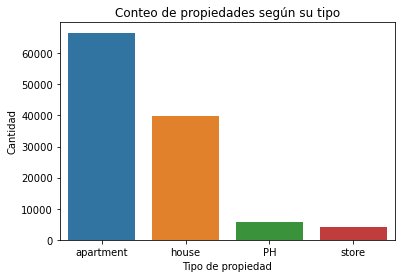

In [15]:
# Gráfico de barras para el conteo de los registros por tipo de propiedad

sns.countplot(data = data, x = 'property_type', order = data['property_type'].value_counts().index)
plt.title('Conteo de propiedades según su tipo')
plt.xlabel('Tipo de propiedad')
plt.ylabel('Cantidad')
plt.show()

In [16]:
# Participación de cada tipo de propiedad en el dataset

data['property_type'].value_counts(normalize=True)

apartment   0.573704
house       0.342354
PH          0.048881
store       0.035061
Name: property_type, dtype: float64

Se evidencia una participación importante propiedades como apartamentos y casas, los cuales de forma conjunta representan aproximadamente el **92%** de todo el dataset, mientras que la participación restante la tienen los penthouse y las tiendas. 

#### Distribución de áreas según el tipo de propiedad

##### Áreas de apartamentos

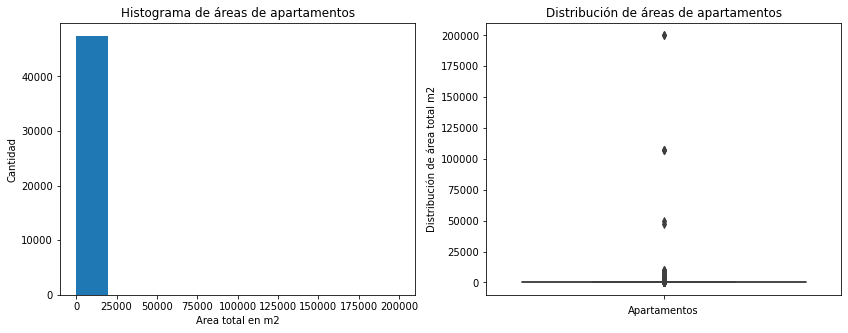

In [17]:
areas_apartamentos = data.loc[data['property_type']=='apartment','surface_total_in_m2']

plt.figure(1, figsize=(14,5))
plt.title('Distribución de áreas totales de apartamentos')

plt.subplot(1,2,1)
plt.title('Histograma de áreas de apartamentos')
plt.hist(areas_apartamentos)
plt.xlabel('Area total en m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de áreas de apartamentos')
sns.boxplot(y=areas_apartamentos)
plt.xlabel('Apartamentos')
plt.ylabel('Distribución de área total m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a las 20 hectáreas los más extremos, los cuales si queremos ejemplificar serían polígonos rectangulares de 200m x 1000m.

##### Áreas de casas

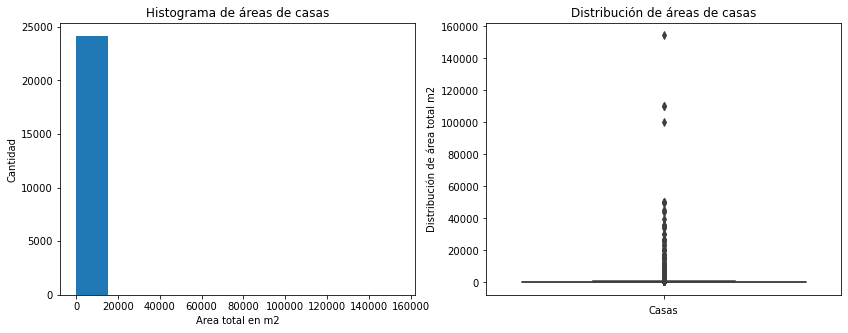

In [18]:
# Distribución de áreas de casas
areas_apartamentos = data.loc[data['property_type']=='house','surface_total_in_m2']


plt.figure(1, figsize=(14,5))
plt.title('Distribución de áreas totales de casas')

plt.subplot(1,2,1)
plt.title('Histograma de áreas de casas')
plt.hist(areas_apartamentos)
plt.xlabel('Area total en m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de áreas de casas')
sns.boxplot(y=areas_apartamentos)
plt.xlabel('Casas')
plt.ylabel('Distribución de área total m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a las 16 hectáreas los más extremos, los cuales si queremos ejemplificar serían polígonos rectangulares de 400m x 400m.

##### Áreas de penthouses

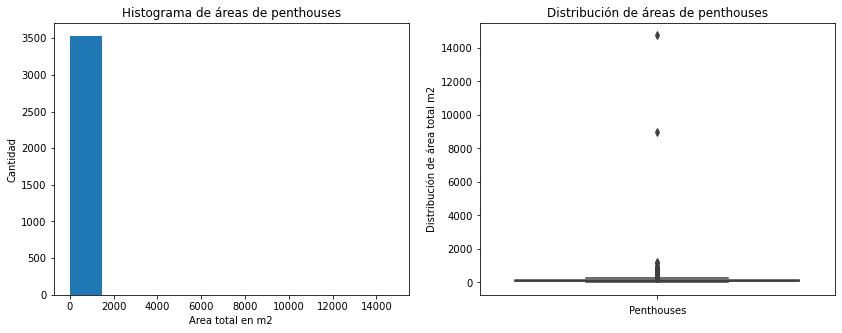

In [19]:
# Distribución de áreas de penthouses
areas_apartamentos = data.loc[data['property_type']=='PH','surface_total_in_m2']


plt.figure(1, figsize=(14,5))
plt.title('Distribución de áreas totales de penthouses')

plt.subplot(1,2,1)
plt.title('Histograma de áreas de penthouses')
plt.hist(areas_apartamentos)
plt.xlabel('Area total en m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de áreas de penthouses')
sns.boxplot(y=areas_apartamentos)
plt.xlabel('Penthouses')
plt.ylabel('Distribución de área total m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a las 1.4 hectáreas los más extremos, los cuales si queremos ejemplificar serían polígonos rectangulares de 118m x 118m.

##### Áreas de tiendas

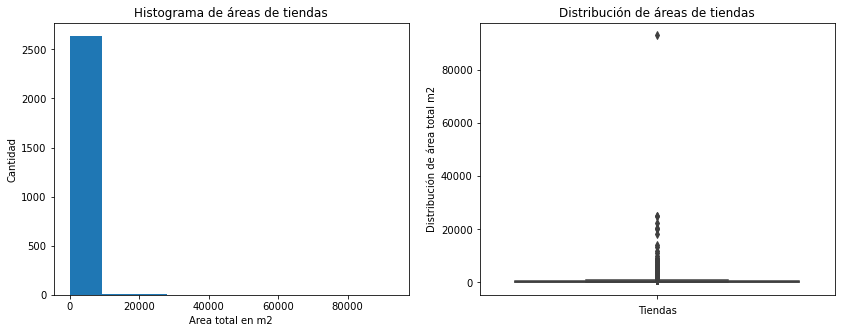

In [20]:
# Distribución de áreas de tiendas
areas_apartamentos = data.loc[data['property_type']=='store','surface_total_in_m2']


plt.figure(1, figsize=(14,5))
plt.title('Distribución de áreas totales de tiendas')

plt.subplot(1,2,1)
plt.title('Histograma de áreas de tiendas')
plt.hist(areas_apartamentos)
plt.xlabel('Area total en m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de áreas de tiendas')
sns.boxplot(y=areas_apartamentos)
plt.xlabel('Tiendas')
plt.ylabel('Distribución de área total m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a las 9 hectáreas los más extremos, los cuales si queremos ejemplificar serían polígonos rectangulares de 300m x 300m.

#### Precio por metro cuadrado en función del tipo de propiedad

##### Precios de apartamentos

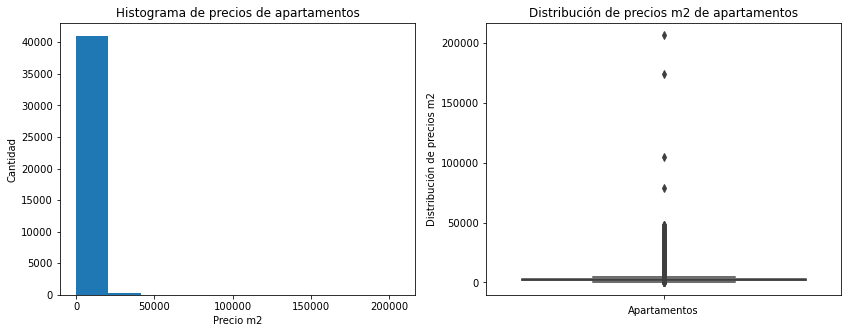

In [21]:
precios = data.loc[data['property_type']=='apartment','price_usd_per_m2']

plt.figure(1, figsize=(14,5))

plt.subplot(1,2,1)
plt.title('Histograma de precios de apartamentos')
plt.hist(precios)
plt.xlabel('Precio m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de precios m2 de apartamentos')
sns.boxplot(y=precios)
plt.xlabel('Apartamentos')
plt.ylabel('Distribución de precios m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a los 200.000 dólares el m2

##### Precios de casas

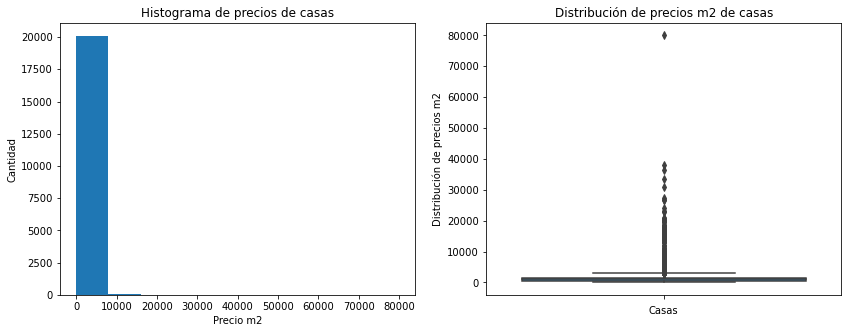

In [22]:
precios = data.loc[data['property_type']=='house','price_usd_per_m2']

plt.figure(1, figsize=(14,5))

plt.subplot(1,2,1)
plt.title('Histograma de precios de casas')
plt.hist(precios)
plt.xlabel('Precio m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de precios m2 de casas')
sns.boxplot(y=precios)
plt.xlabel('Casas')
plt.ylabel('Distribución de precios m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a los 80.000 dólares el m2.

##### Precios de PH

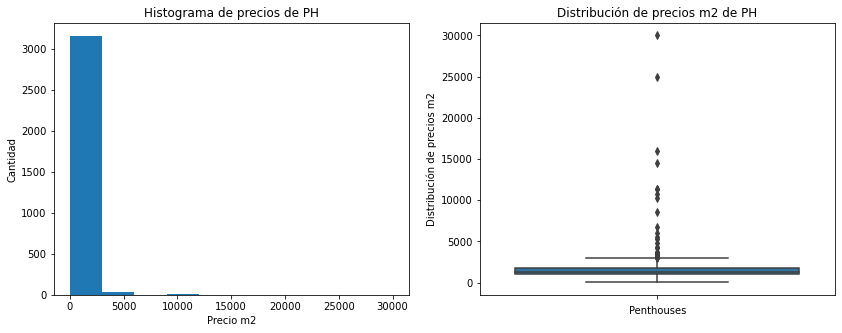

In [23]:
precios = data.loc[data['property_type']=='PH','price_usd_per_m2']

plt.figure(1, figsize=(14,5))

plt.subplot(1,2,1)
plt.title('Histograma de precios de PH')
plt.hist(precios)
plt.xlabel('Precio m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de precios m2 de PH')
sns.boxplot(y=precios)
plt.xlabel('Penthouses')
plt.ylabel('Distribución de precios m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a los 30.000 dólares el m2

##### Precios de tiendas

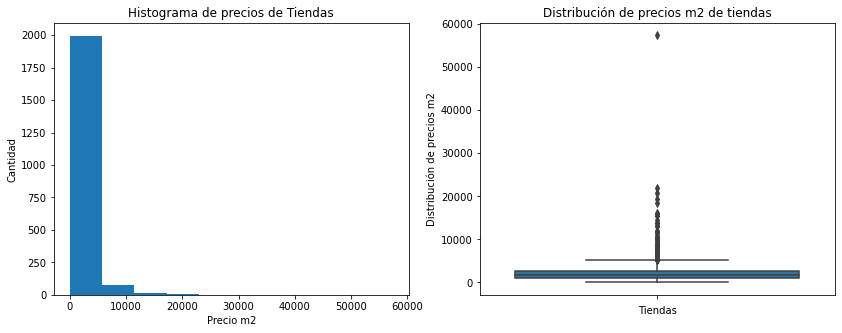

In [24]:
precios = data.loc[data['property_type']=='store','price_usd_per_m2']

plt.figure(1, figsize=(14,5))

plt.subplot(1,2,1)
plt.title('Histograma de precios de Tiendas')
plt.hist(precios)
plt.xlabel('Precio m2')
plt.ylabel('Cantidad')

plt.subplot(1,2,2)
plt.title('Distribución de precios m2 de tiendas')
sns.boxplot(y=precios)
plt.xlabel('Tiendas')
plt.ylabel('Distribución de precios m2')
plt.show()

Se evidencia la presencia de outliers, con valores cercanos a los 60.000 dólares el m2

#### Distribución de la variable state_name

In [36]:
# Calculamos la participación porcentual de cada state_name

state_name_dist = pd.DataFrame(data['state_name'].value_counts(normalize=True))

# Calculamos la participación acumulada de state_name, yendo de estados con mayor participación a aquellos con menor participación.

state_name_dist['participa_acum'] = state_name_dist['state_name'].cumsum()

In [43]:
print('La cantidad de state_name distintos es: ', state_name_dist.shape[0])

La cantidad de state_name distintos es:  28


In [41]:
state_name_dist.head(10)

,state_name,participa_acum
Capital Federal,0.264724,0.264724
Bs.As. G.B.A. Zona Norte,0.213260,0.477983
Bs.As. G.B.A. Zona Sur,0.116730,0.594713
Córdoba,0.099750,0.694464
Buenos Aires Costa Atlántica,0.085362,0.779826
Bs.As. G.B.A. Zona Oeste,0.077906,0.857732
Santa Fe,0.077785,0.935517
Buenos Aires Interior,0.019382,0.954899
Río Negro,0.006819,0.961719
Mendoza,0.005648,0.967367


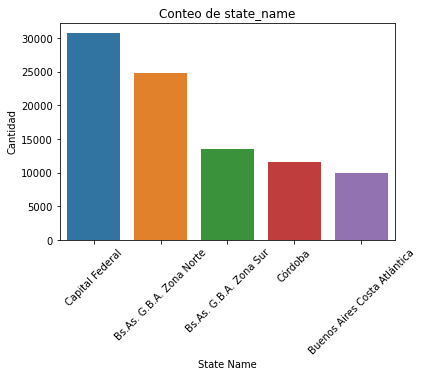

In [40]:
# Gráfico de barras para el conteo de state_name con participación conjunta cercana al 80% del dataset

filtro = state_name_dist.loc[state_name_dist['participa_acum']<=0.80].index
sns.countplot(data = data.loc[data['state_name'].isin(filtro)], 
              x = 'state_name', order = filtro)
plt.title('Conteo de state_name')
plt.xlabel('State Name')
plt.xticks(rotation = 45)
plt.ylabel('Cantidad')
plt.show()

Podemos observar que cerca del 80% de la data se concentra en aproximadamente el 20% de los estados, en este caso 5 de 28 estados que aparecen en la data.

#### Distribución de la variable place_name

In [45]:
# Calculamos la participación porcentual de cada place_name

place_name_dist = pd.DataFrame(data['place_name'].value_counts(normalize=True))

# Calculamos la participación acumulada de place_name, yendo de estados con mayor participación a aquellos con menor participación.

place_name_dist['participa_acum'] = place_name_dist['place_name'].cumsum()

In [46]:
print('La cantidad de place_name distintos es: ', place_name_dist.shape[0])

La cantidad de place_name distintos es:  1060


In [59]:
place_name_dist.head(25)

,place_name,participa_acum
Córdoba,0.075880,0.075880
Rosario,0.063643,0.139523
Mar del Plata,0.055866,0.195389
Tigre,0.027446,0.222836
Nordelta,0.026215,0.249051
Belgrano,0.024501,0.273552
Palermo,0.023606,0.297157
La Plata,0.020987,0.318145
Pilar,0.018964,0.337108
Caballito,0.018817,0.355925


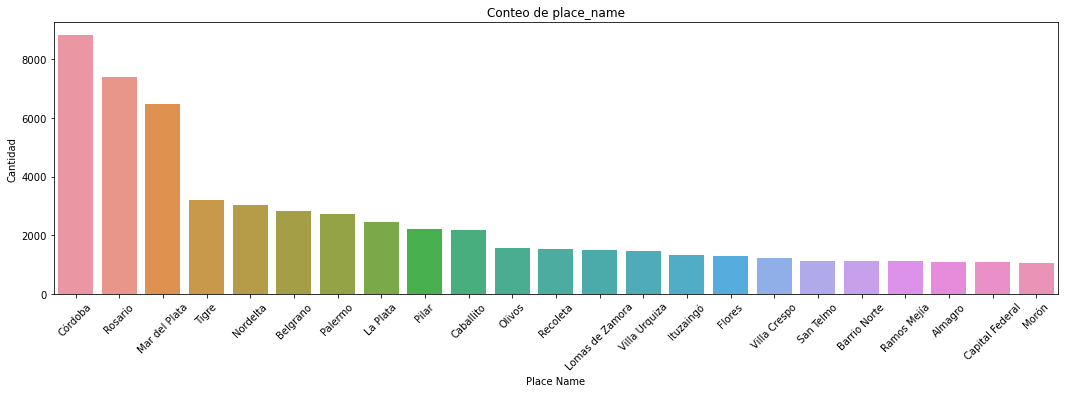

In [56]:
# Gráfico de barras para el conteo de state_name con participación conjunta cercana al 80% del dataset

plt.figure(1, figsize=(18,5))

filtro = place_name_dist.loc[place_name_dist['participa_acum']<=0.50].index
sns.countplot(data = data.loc[data['place_name'].isin(filtro)], 
              x = 'place_name', order = filtro)
plt.title('Conteo de place_name')
plt.xlabel('Place Name')
plt.xticks(rotation = 45)
plt.ylabel('Cantidad')
plt.show()

In [64]:
print(place_name_dist.loc[place_name_dist['participa_acum']<=0.5].shape[0])
print(place_name_dist.loc[place_name_dist['participa_acum']<=0.5].shape[0]/place_name_dist.shape[0])
print(place_name_dist.loc[place_name_dist['participa_acum']<=0.8].shape[0])
print(place_name_dist.loc[place_name_dist['participa_acum']<=0.8].shape[0]/place_name_dist.shape[0])

23
0.02169811320754717
94
0.08867924528301886


Podemos observar que cerca del 50% de la data se concentra en aproximadamente el 2.2% de los place_name, en este caso 23 de 1060 estados que aparecen en la data.

Para cubrir el 80% de la data, se requieren 94 place_name, que representan aproximadamente el 8.9% de los lugares que aparecen en la data.

#### Matriz de correlación

Construimos la matriz de correlación para buscar de forma preliminar variables con alto potencial de poder predictivo.

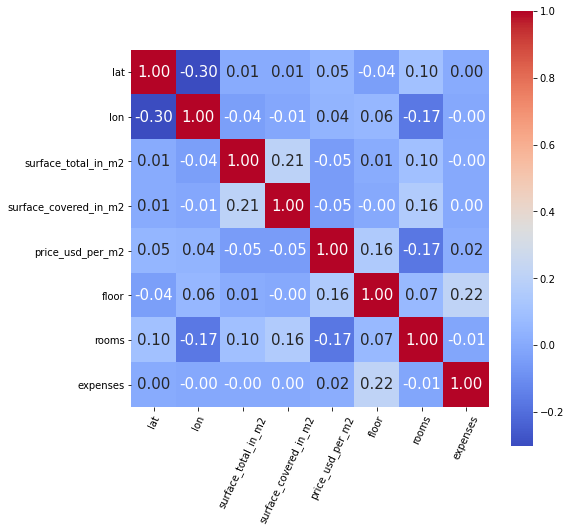

In [65]:
# Matriz de correlación

var_numericas = ['lat', 'lon', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 
                 'rooms', 'expenses']

var_categoricas = ['place_name', 'country_name', 'state_name', 'property_type', 'currency']

corr = data[(var_numericas+var_categoricas)].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},cmap= 'coolwarm') 
plt.xticks(rotation = 65)
plt.yticks(rotation = 0)
plt.show()

### Conclusiones

* En la fase de limpieza de datos, es necesario eliminar algunas columnas, una de ellas la url del inmueble para posteriormente eliminar los registros duplicados, ya que se encuentran alrededor de 5080 de estos, los cuales cuando se suben a la página más de una vez, se generan con una url diferente.

* Se presentan valores extremos para precios por metro cuadrado y superficies en función del tipo de propiedad.

* De acuerdo a las distribuciones encontradas en la información, creemos que es conveniente centrarnos en aquellos tipos de propiedad como casas y/o apartamentos, los cuales cuentan con una participación cercana al 92% de la información.

* En cuando a los state_name, encontramos que con tan solo fijarnos en 5 de estos, contamos con cerca del 80% de la información.

* Finalmente, de acuerdo a la distribución de place_name, con tan solo 23 lugares, contamos con cerca del 50% de la data.

De acuerdo a lo anterior, podemos explorar modelos con combinaciones reducidas de property_type, state_name y place_name de modo que contemos con una proporción de data significativa.